In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
from ema_workbench.analysis import feature_scoring
from Convience_fun import create_scenario
import warnings
warnings.filterwarnings("ignore")
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Scenario

)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench import perform_experiments
from ema_workbench import Samplers
from ema_workbench import SequentialEvaluator
from ema_workbench.em_framework.parameters import Constant
import pickle
import itertools

In [2]:
dike_model, planning_steps = get_model_for_problem_formulation(6)

In [3]:
with open("data\ScenariosOpenExplo2.0", 'rb') as f:
    scen_prim = pickle.load(f)

In [4]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scen_prim,1)

100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.80it/s]


In [5]:
experiments, outcomes = results

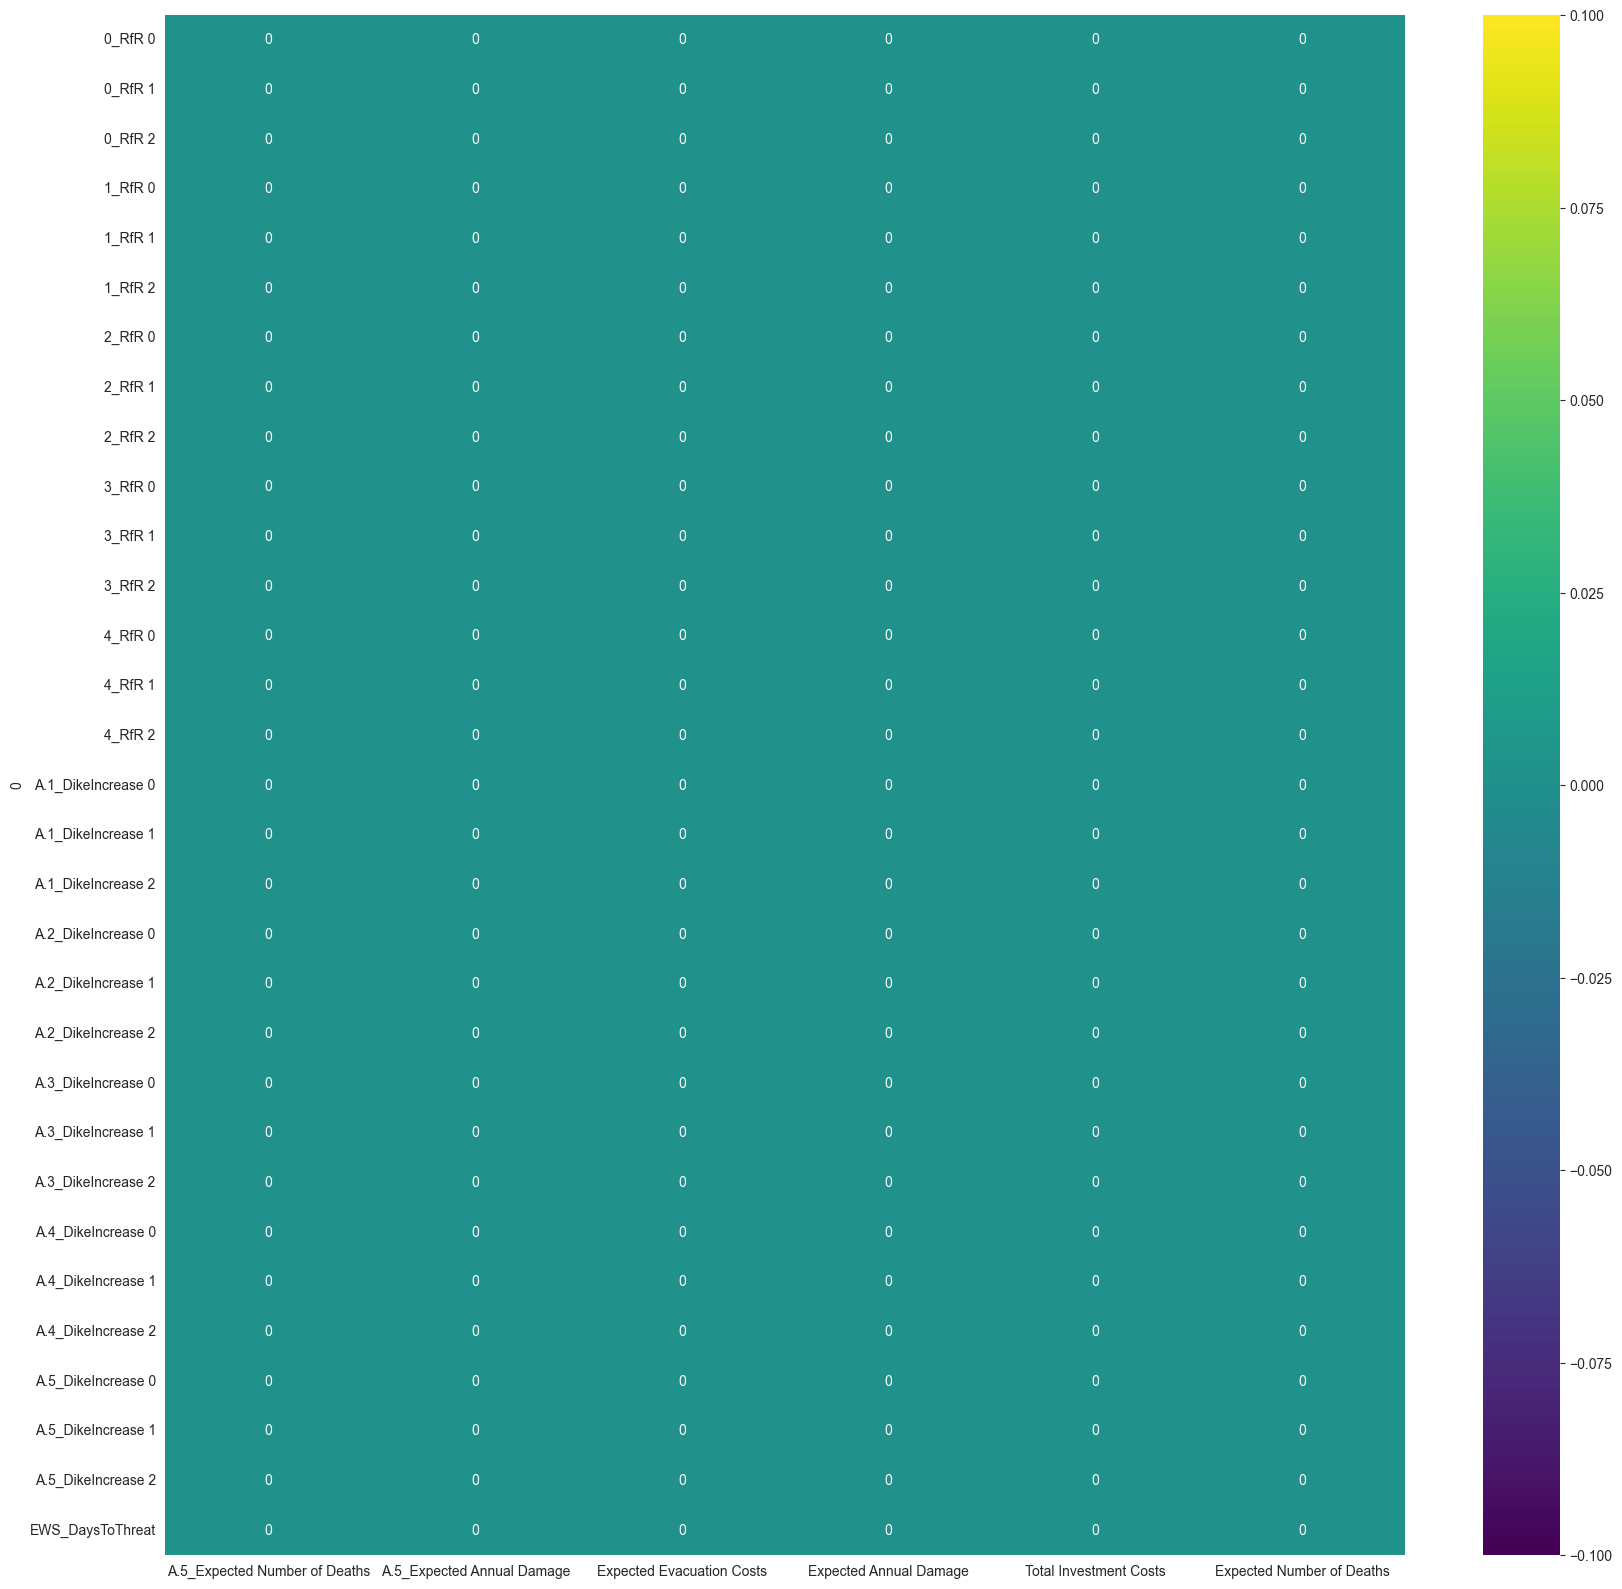

In [6]:
experiments_unc = experiments.iloc[:, 19:]
outcomes.keys()
df = pd.DataFrame(outcomes)

# df["Expected Annual Damage"] = df["A.1_Expected Annual Damage"] + df["A.2_Expected Annual Damage"] + df[
#     "A.3_Expected Annual Damage"] + df["A.4_Expected Annual Damage"] + df["A.5_Expected Annual Damage"]
# df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df[
#     "A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]
# df_feature_importance_out = df[["Expected Evacuation Costs","Expected Annual Damage", "Expected Number of Deaths", "A.5_Expected Number of Deaths",
#                                 "A.5_Expected Annual Damage"]]

x = experiments_unc
y = df
fig, ax = plt.subplots(figsize=(20,20))
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True,ax=ax)
plt.show()

In [7]:
from ema_workbench.analysis import RuleInductionType

y = ((df["Expected Evacuation Costs"] >= list(np.sort(df["Expected Evacuation Costs"]))[int(0.80* len(df["Expected Evacuation Costs"]))]))

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=RuleInductionType.CLASSIFICATION)

fs.sort_values(ascending=False, by=1).head(10)

,1
0,
0_RfR 0,0.0
A.1_DikeIncrease 1,0.0
A.5_DikeIncrease 2,0.0
A.5_DikeIncrease 1,0.0
A.5_DikeIncrease 0,0.0
A.4_DikeIncrease 2,0.0
A.4_DikeIncrease 1,0.0
A.4_DikeIncrease 0,0.0
A.3_DikeIncrease 2,0.0


In [8]:
from ema_workbench.analysis import RuleInductionType

y = ((df["A.5_Expected Number of Deaths"] > list(np.sort(df["A.5_Expected Number of Deaths"]))[np.int64(0.80* len(df["A.5_Expected Number of Deaths"]))])
    |(df['A.5_Expected Annual Damage'] > list(np.sort(df['A.5_Expected Annual Damage']))[np.int64(0.80* len(df['A.5_Expected Annual Damage']))])
     )

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=RuleInductionType.CLASSIFICATION)

fs.sort_values(ascending=False, by=1).head(10)

,1
0,
0_RfR 0,0.0
A.1_DikeIncrease 1,0.0
A.5_DikeIncrease 2,0.0
A.5_DikeIncrease 1,0.0
A.5_DikeIncrease 0,0.0
A.4_DikeIncrease 2,0.0
A.4_DikeIncrease 1,0.0
A.4_DikeIncrease 0,0.0
A.3_DikeIncrease 2,0.0


In [9]:
from ema_workbench.analysis import RuleInductionType

y = (
    (df['Expected Number of Deaths'] > list(np.sort(df["Expected Number of Deaths"]))[np.int64(0.8* len(df['Expected Number of Deaths']))])
     |(df['Expected Annual Damage'] > list(np.sort(df["Expected Annual Damage"]))[np.int64(0.8* len(df['Expected Annual Damage']))])
     )

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=RuleInductionType.CLASSIFICATION)

fs.sort_values(ascending=False, by=1).head(10)

,1
0,
0_RfR 0,0.0
A.1_DikeIncrease 1,0.0
A.5_DikeIncrease 2,0.0
A.5_DikeIncrease 1,0.0
A.5_DikeIncrease 0,0.0
A.4_DikeIncrease 2,0.0
A.4_DikeIncrease 1,0.0
A.4_DikeIncrease 0,0.0
A.3_DikeIncrease 2,0.0


### SOBOL

In [10]:
dike_model_1, planning_steps = get_model_for_problem_formulation(6)

dele = []

for x in dike_model_1.levers:

    if x.name not in ["3_RfR 2","3_RfR 1","3_RfR 0","A.5_DikeIncrease 0","A.5_DikeIncrease 1","EWS_DaysToThreat"]:

        dele.append(x.name)

for i in dele:
    dike_model_1.levers.__delitem__(i)

    dike_model_1.constants.extend(Constant(i,0))

In [11]:
with MultiprocessingEvaluator(dike_model_1) as evaluator:
    results = evaluator.perform_experiments(scen_prim,1,lever_sampling=Samplers.SOBOL)

100%|██████████████████████████████████████████| 42/42 [00:06<00:00,  6.76it/s]


In [12]:
experiments_1, outcomes_1 = results

In [13]:
experiments_levers = experiments_1.iloc[:, 19:-3]

In [14]:

df = pd.DataFrame(outcomes_1)
# df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df[
#     "A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]
# 
# df["Expected Annual Damage"] = df["A.1_Expected Annual Damage"] + df["A.2_Expected Annual Damage"] + df["A.3_Expected Annual Damage"] + df["A.4_Expected Annual Damage"] + df["A.5_Expected Annual Damage"]
# 
# df_feature_importance_out = df[["Expected Annual Damage", "Expected Number of Deaths","A.5_Expected Annual Damage", "A.5_Expected Number of Deaths", "A.5 Total Costs"]]
# ## Feature importance


In [15]:
outcomes_1["Expected Number of Deaths"] = df["Expected Number of Deaths"]
outcomes_1["Expected Annual Damage"] = df["Expected Annual Damage"]

In [16]:
problem

NameError: name 'problem' is not defined

In [ ]:
list(dike_model_1.levers)

In [ ]:
problem = get_SALib_problem(dike_model_1.levers)

sns.set_style('white')
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax = ax.flatten()

for index, kpi in enumerate(df.columns):
    Si = sobol.analyze(problem, np.array(outcomes_1[kpi]), calc_second_order=True, print_to_console=False)
    Si_filter = {k: Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    indices = Si_df[['S1', 'ST']]
    err = Si_df[['S1_conf', 'ST_conf']]
    ax[index].title.set_text(kpi)
    indices.plot.bar(yerr=err.values.T, ax=ax[index])
    # fig.set_size_inches(8,6)
    # fig.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()